In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [89]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib
import uproot # 4

In [34]:
def deltar(df):
    df['tc_deta'] = df['tc_eta']-df['genpart_exeta']
    df['tc_dphi'] = np.abs(df['tc_phi']-df['genpart_exphi'])
    sel = df['tc_dphi']>np.pi
    df['tc_dphi'] -= sel*(2*np.pi)
    return(np.sqrt(df['tc_dphi']*df['tc_dphi']+df['tc_deta']*df['tc_deta']))

In [4]:
file_name = '../CMSSW_12_5_0_pre4/src/L1Trigger/L1THGCalUtilities/test/ntuple_RelValSingleEFlatPt2To100_2026D88noPU.root'
tree_name = 'hgcalTriggerNtuplizer/HGCalTriggerNtuple'
branches_gen=['event','genpart_pid','genpart_exphi', 'genpart_exeta','genpart_gen',
        'genpart_reachedEE', 'genpart_pt', 'genpart_energy']
branches_cl3d=['event', 'cl3d_pt','cl3d_eta','cl3d_phi']
branches_tc = ['event', 'tc_pt', 'tc_mipPt', 'tc_eta', 'tc_phi', 'tc_layer']

In [53]:
tree = uproot.open(file_name)[tree_name]
df_gen = tree.arrays(branches_gen, library='pd')
df_cl = tree.arrays(branches_cl3d, library='pd')
df_tc = tree.arrays(branches_tc, library='pd')

In [54]:
sel = df_gen['genpart_gen']!=-1
df_gen = df_gen[sel]
sel = df_gen['genpart_reachedEE']==2
df_gen = df_gen[sel]
#sel = df_gen['genpart_pt']>20
#df_gen = df_gen[sel]
sel = np.abs(df_gen['genpart_exeta'])>1.7
df_gen = df_gen[sel]
sel = np.abs(df_gen['genpart_exeta'])<2.8
df_gen = df_gen[sel]
df_gen_pos = df_gen[df_gen['genpart_exeta']>0]
df_gen_neg = df_gen[df_gen['genpart_exeta']<0]
df_gen_pos.set_index('event', inplace=True)
df_gen_neg.set_index('event', inplace=True)

In [55]:
df_cl_pos = df_cl[df_cl['cl3d_eta']>0]
df_cl_neg = df_cl[df_cl['cl3d_eta']<0]
df_cl_pos.set_index('event', inplace=True)
df_cl_neg.set_index('event', inplace=True)

sel = df_tc['tc_layer']<28
df_tc = df_tc[sel]
sel = df_tc['tc_mipPt']>0.5
df_tc = df_tc[sel]
df_tc_pos = df_tc[df_tc['tc_eta']>0]
df_tc_neg = df_tc[df_tc['tc_eta']<0]
df_tc_pos.set_index('event', inplace=True)
df_tc_neg.set_index('event', inplace=True)

In [69]:
#df_pos = df_gen_pos.join(df_cl_pos, how='left', rsuffix='_cl')
#df_neg = df_gen_neg.join(df_cl_neg, how='left', rsuffix='_cl')
df_pos = df_gen_pos.join(df_tc_pos, how='left', rsuffix='_cl')
df_neg = df_gen_neg.join(df_tc_neg, how='left', rsuffix='_cl')

In [74]:
df_pos

,genpart_pid,genpart_exphi,genpart_exeta,genpart_gen,genpart_reachedEE,genpart_pt,genpart_energy,tc_pt,tc_mipPt,tc_eta,tc_phi,tc_layer,zside,tc_deta,tc_dphi,tc_deltar
event,,,,,,,,,,,,,,,,
5,11,-2.392516,2.516547,2,2,34.108475,213.574371,0.040656,1.393841,2.475509,-2.357290,23,1,-0.041038,0.035226,0.054083
5,11,-2.392516,2.516547,2,2,34.108475,213.574371,0.021793,0.747156,2.493161,-2.488088,9,1,-0.023386,0.095572,0.098392
5,11,-2.392516,2.516547,2,2,34.108475,213.574371,0.038324,3.231504,2.495096,-2.376636,1,1,-0.021451,0.015881,0.026690
5,11,-2.392516,2.516547,2,2,34.108475,213.574371,0.024590,2.073441,2.452729,-2.386977,1,1,-0.063818,0.005539,0.064058
5,11,-2.392516,2.516547,2,2,34.108475,213.574371,0.030266,1.037640,2.571177,-2.430912,3,1,0.054630,0.038396,0.066773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,-11,-0.034462,1.755246,3,2,6.865525,20.526646,0.018173,0.623042,1.734676,0.022954,3,1,-0.020570,0.057416,0.060989
8999,-11,-0.034462,1.755246,3,2,6.865525,20.526646,0.059922,2.054343,1.746242,-0.007267,17,1,-0.009003,0.027195,0.028646
8999,-11,-0.034462,1.755246,3,2,6.865525,20.526646,0.044955,1.541205,1.745933,-0.026641,17,1,-0.009312,0.007821,0.012161


In [71]:
df_pos['zside'] = 1
df_neg['zside'] = -1
df_pos['tc_deltar'] = deltar(df_pos)
df_neg['tc_deltar'] = deltar(df_neg)
sel = df_pos.tc_deltar<0.1
df_pos = df_pos[sel]
sel = df_neg.tc_deltar<0.1
df_neg = df_neg[sel]
df = pd.concat([df_pos, df_neg])

In [78]:
df['bin_pt'] = (df.genpart_pt/10.).astype('int32')
columns = ['event', 'zside', 'bin_pt', 'tc_layer', 'tc_pt', 'tc_mipPt']
sum_layers = df.reset_index()[columns]\
.groupby(['event', 'zside', 'bin_pt', 'tc_layer']).sum().reset_index()
sum_layers

,event,zside,bin_pt,tc_layer,tc_pt,tc_mipPt
0,5,-1,3,1,0.068973,5.815888
1,5,-1,3,3,1.841343,63.129410
2,5,-1,3,5,4.166018,142.829590
3,5,-1,3,7,6.669609,228.663773
4,5,-1,3,9,6.234424,213.743729
...,...,...,...,...,...,...
72292,8999,1,0,15,0.479034,16.423008
72293,8999,1,0,17,0.368617,12.637530
72294,8999,1,0,21,0.021758,0.745931
72295,8999,1,0,25,0.015928,0.546058


In [60]:
def profile(event):
    sum_pt = np.sum(event.tc_pt)
    sum_mipPt = np.sum(event.tc_mipPt)
    event.tc_pt /= sum_pt
    event.tc_mipPt /= sum_mipPt
    return event


In [83]:
longitudinal_profile = sum_layers.groupby(['event', 'zside']).apply(profile).reset_index()
mean_profile = longitudinal_profile.groupby(['bin_pt', 'tc_layer']).mean().reset_index()
mean_profile

,bin_pt,tc_layer,index,event,zside,tc_pt,tc_mipPt
0,0,1,36339.723312,4505.557734,-0.010893,0.021877,0.048679
1,0,3,36257.625793,4494.739958,-0.006342,0.167564,0.161483
2,0,5,36203.747881,4488.078390,-0.004237,0.231966,0.225452
3,0,7,36069.733906,4471.049356,0.000000,0.215196,0.210066
4,0,9,35989.503212,4461.038544,-0.006424,0.162460,0.158330
...,...,...,...,...,...,...,...
135,9,19,37326.787086,4627.821990,0.015707,0.025157,0.025060
136,9,21,37327.787086,4627.821990,0.015707,0.011761,0.011717
137,9,23,37328.787086,4627.821990,0.015707,0.005031,0.005012
138,9,25,37376.212613,4633.421622,0.012613,0.002110,0.002101


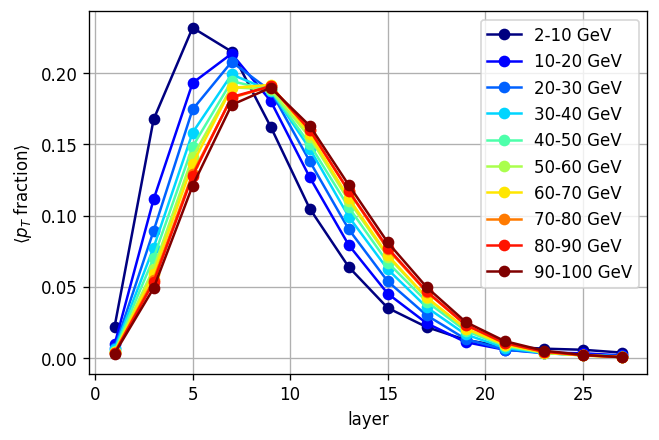

In [101]:
n = 10
colors = pl.cm.jet(np.linspace(0,1,n))
legends = [
   '2-10 GeV', 
   '10-20 GeV', 
   '20-30 GeV', 
   '30-40 GeV', 
   '40-50 GeV', 
   '50-60 GeV', 
   '60-70 GeV', 
   '70-80 GeV', 
   '80-90 GeV', 
   '90-100 GeV', 
]
plt.figure(dpi=120)
for bin_pt in range(n):
    plt.plot(mean_profile[mean_profile.bin_pt==bin_pt].set_index('tc_layer').tc_pt,
             'o-',
             color=colors[bin_pt],
            label=legends[bin_pt])
plt.xlabel('layer')
plt.ylabel(r'$\langle p_{T}$ fraction$\rangle$')
plt.grid()
plt.legend()
plt.show()

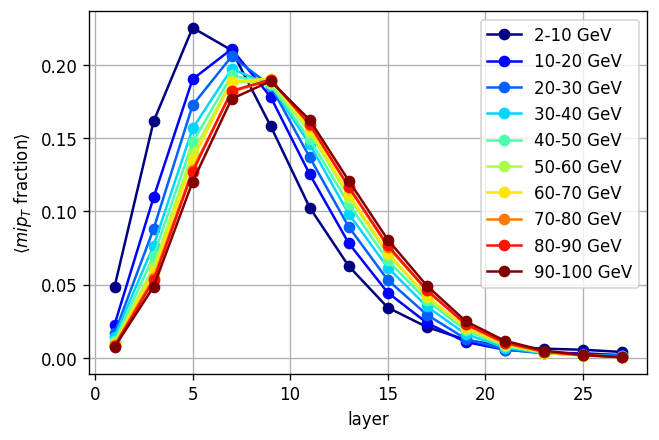

In [100]:
plt.figure(dpi=120)
for bin_pt in range(n):
    plt.plot(mean_profile[mean_profile.bin_pt==bin_pt].set_index('tc_layer').tc_mipPt,
             'o-',
             color=colors[bin_pt],
            label=legends[bin_pt])
plt.xlabel('layer')
plt.ylabel(r'$\langle mip_{T}$ fraction$\rangle$')
plt.grid()
plt.legend()
plt.show()